# Streamgraph Plain Text
This notebook takes you through making a streamgraph of plain text data. You can do multiple files or a single file. A streamgraph shows where terms appear in linear context of a dataset. For single documents, the document is broken up into chunks of words and the streamgraph shows how often your words of interest appear in each chunk. For multiple files the files are the chunks. A streamgraph helps to investigate how words are used across a dataset and compare multiple words and their use in the data.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.    

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by simply typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:   


- **nltk:** A leading platform for building Python programs to work with human language data.
- **string:** Contains a number of functions to process standard Python strings.
- **math:** Provides access to the mathematical functions defined by the C standard.
- **numpy:** The fundamental package for scientific computing with Python.
- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
- **os:** Provides a portable way of using operating system dependent functionality.
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **scipy:** Open-source software for mathematics, science, and engineering. The SciPy library depends on NumPy, which provides convenient and fast N-dimensional array manipulation.
- **ggplot:** a Python implementation of the grammar of graphics.

In [2]:
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
import string
import math
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, isfile, splitext
import pandas as pd
from scipy.stats import rankdata
from ggplot import *

#### File paths
Here we are saving as variables different file paths that we need in our code. 

First we us the `os` package above to find our 'HOME' directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your 'home' directory, so no changes are needed.

Next, we combine the `homePath` file path with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one. There are options below for doing both. We save the path as a variable named `dataHome`.

Now we add the `homePath` file path to other folder names that lead to a folder where we will want to save any output generated by this code. We again will change the file names in the appropriate cells down below. We save this file path as the variable `dataResults`.

Lastly, we use the file path from `dataHome` to point to the directory where our data is stored and save that as `dataResults`.

In [3]:
homePath = os.environ['HOME']
dataHome = os.path.join(homePath, 'Text-Analysis-master', 'data', 'shakespeareFolger')
dataResults = os.path.join(homePath, 'Text-Analysis-master', 'Output')

### Set needed variables
This is where you will make some decisions about your data and set the necessary variables. We again do this so you will not need to make as many changes to the code later.

Your data needs to be in a '.txt' file format to work with this notebook. If it is then you need to specify if you want to read in a single document or an entire directory. If you want to read in a single document, then set `singleDoc` equal to **True**. If you want to read in an entire directory of documents then set `singleDoc` equal to **False**.

The `nltkStop` is where you determine if you want to use the built in stopword list provided by the NLTK package. They provide stopword lists in multiple languages. If you wish to use this then set `nltkStop` equal to **True**. If you do not, then set `nltkStop` equal to **False**. For streamgraphs removing stopwords is not necessary as you are searching for specific words in your dataset. However, if your data is a single document, then we will be breaking the data into chunks based on word counts. Leaving in stopwords or removing them can alter the number of chunks and which chunks your words of interest appear in, so make this choice based on what works best for your data.

The `customStop` variable is for if you have a dataset that contains additional stopwords that you would like to read in and have added to the existing `stopWords` list. You do **NOT** need to use the NLTK stopwords list in order to add your own custom list of stopwords. **NOTE: Your custom stopwords file needs to have one word per line as it reads in a line at a time and the full contents of the line is read in and added to the existing stopwords list.** If you have a list of your own then set `customStop` equal to **True**. If you do not have your own custom stopwords list then set `customStop` equal to **False**. The same thing applies here as to the `nltkStop` variable regarding streamgraphs and stopwords in a single document. 

The `stopLang` variable is to choose the language of the nltk stopword list you wish to use. It is currently set to `'english'`. If you need a different language, simply change `'english'` to the anglicized name of the language you wish to use (e.g. 'spanish' instead of 'espanol' or 'german' instead of 'deutsch'). If you need to see the list of available languages in nltk simply remove the `#` from in front of `#print(" ".join(stopwords.fileids()))` and run the cell. A list of available languages will display below the cell. 

The `stopWords = []` is an empty list that will contain the final list of stop words to be removed form your dataset. What ends up in the list depends on whether you set `nltkStop` and/or `customStop` equal to **True** or **False** and if you add any additional words to the list.

The `interestedWords` variable is where you insert your words of interest. Make sure to put each word in quotes and separate them with a comma. Remember, you will see how often each word occurs in each chunk simultaneously, so too many words may make the graph hard to read.

The `freqDict` variable is an empty dictionary which will be filled with words and their frequencies further down in the code.

In [4]:
singleDoc = False
nltkStop = True
customStop = True
stopLang = 'english'
stopWords = []
interestedWords = ['night', 'death', 'love']
freqDict = {}

#print(" ".join(stopwords.fileids()))

### Stopwords
If you set `nltkStop` equal to **True** above then this will add the nltk stopwords list to the empty list named `stopWords`. You should already have chosen your language above, so there is no need to do that here.

If you wish to add additional words to the `stopWords` list, add the word in quotes to the list in `stopWords.extend(['the', 'words', 'you', 'want', 'to', 'add'])`.

In [5]:
# NLTK Stop words
if nltkStop is True:
    stopWords.extend(stopwords.words(stopLang))

    stopWords.extend(['would', 'said', 'says', 'also', 'good', 'lord', 'come'])

#### Add own stopword list

Here is where your own stopwords list is added if you selected **True** in `customStop` above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct path order, always putting the file name including the file extension ('.txt') last.

In [6]:
if customStop is True:
    stopWordsFilepath = os.path.join(homePath, "Text-Analysis-master", "data", "earlyModernStopword.txt")

    with open(stopWordsFilepath, "r",encoding = 'utf-8') as stopfile:
        stopWordsCustom = [x.strip() for x in stopfile.readlines()]

    stopWords.extend(stopWordsCustom)

### Functions
We need to create a few functions in order to calculate and create a streamgraph. Any time you see `def` that means we are *DE*claring a *F*unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

#### Text Cleaning

These functions do some text cleaning for us and require the parameters: `token` for the `allPuncChar` function and `words` for the `clean` function.

This function removes punctuation and is used as part of the `clean` function immediately preceding this cell of code. This function looks at each word and compares it to a list of punctuation. If the word is not in the list, then it returns as **False**. Then the function returns all tokens that were labeled as **True**, which should be only punctuation.

In [7]:
def allPuncChar(token):
    
    for c in token:
        
        if c not in string.punctuation:
            return False
        
    return True

Now we come to the text cleaning function, `clean`. First the function lowercases the text or else 'Love' and 'love' will be counted as two different words, so we make them all 'love'. We assign this list of lowercased words to the variable `words`.

Then we remove stopwords by reassigning a list that contains words that are not in the `stopWords` variable from before to our `words` variable. 

Next we remove punctuation using the `allPuncChar` function from above. This will compare our current `words` variable to the list of punctuation we created in the `allPuncChar` function and put those words which are not in the `allPuncChar` list into another list and reassign that list to the variable ` words`.

Lastly, we remove numbers using the `isnumeric` function from the most recent `words` variable. If a word in our `words` variable is not numeric, then we add it to a new list and reassign that list to the variable `words`.

In [8]:
def clean(words):
    ################
    # cleanup
    ################

    # to lower case
    words = [w.lower() for w in words]

    # step 2: built in list
    builtinList = set(stopWords) # convert from list to set for fast lookup
    words = [w for w in words if w not in builtinList]

    # remove punctuations
    words = [w for w in words if not allPuncChar(w)]


    # remove numbers
    words = [w for w in words if not w.isnumeric()]
    
    return words
    

### Read in the corpus

Here we read in the corpus we are going to use. 

First we have two variables where you will make changes. Both of these variables are only necessary if you set `singleDoc` equal to **True** above. The first variable is `textFile` and is the name of the single file you wish to use to create your streamgraph. The second variable is `chunkSize` and is where you will determine how many words you wish to chunk your document into. This number will depend on your data and how many words it contains in all. 

Next, we have an 'if...else' statement. This will run different code based on whether you set `singleDoc` equal to **True** or **False**. If you set it to **True** then it will read in a single document, apply the our `clean` function from above and then break the clean text into the number of chunks specified in our `chunkSize` variable. If you set `singleDoc` equal to **False** then we read in an entire directory of files and apply the `clean` function to them and append the newly cleaned corpus to the list assigned to the variable `words`.

The only changes that need to be made are the two variables at the top of the cell.

In [9]:
textFile = 'RomeoAndJuliet.txt'
chunkSize = 250

if singleDoc is True:

    doc = PlaintextCorpusReader(dataHome, textFile)

    # get tokens
    text = doc.words()

    text = clean(text)
    # chunking

    numberChunks = int(math.ceil(len(text) / chunkSize))

    words = []

    for i in range(numberChunks - 1):

        words.append(text[i * chunkSize : (i + 1) * chunkSize])

    words.append(text[(i + 1) * chunkSize : ])
else:
    # loop over text files
    filenames = [f for f in os.listdir(dataHome) if isfile(os.path.join(dataHome, f))]

    filenames = sorted(filenames, key = lambda x: str(splitext(x)[0]))

    words = []

    for filename in filenames:

        doc = PlaintextCorpusReader(dataHome, filename, encoding = 'ISO-8859-1')

        # get tokens
        text = doc.words()

        text = clean(text)

        words.append(text)

### Count words

Here is where we count how often each word from our `interestedWords` variable occur in each chunk. Remember, if `singleDoc` is **True** the chunks will be based on your choice of how many words are in a chunk, and if it is **False** the chunks are the documents.

In [10]:
# calculate frequency
for w in interestedWords:
    
    freqDict[w] = np.zeros(len(words)).tolist()
    
for idx, word in enumerate(words):
    
    for token in word:
        
        if token in freqDict:
            freqDict[token][idx] += 1

### Emulate R's stat_steamgraph in 'ggTimeSeries' package

This function is meant to emulate the stat_steamgraph function from the ggTimeSeries package in R. You will most likely not need to make any changes here. This function is creating a special data frame (kind of like an excel table) for `ggplot` to be able to read it in a way that it creates a streamgraph from the data.

In [11]:
def composeDataframe(freqDict, debug = False):

    if debug:
        df = pd.DataFrame(data = freqDict)
        print(df)
        print('\n' * 3)


    wordCol = []
    freqCol = []
    seqNum = []
    
    for word in freqDict:
        wordCol.extend([word] * len(freqDict[word]))
        freqCol.extend(freqDict[word])
        seqNum.extend(list(range(1, len(freqDict[word]) + 1)))

    dataDict = {"Term" : wordCol, "Freq" : freqCol, 'SeqNum' : seqNum}

    df = pd.DataFrame(data = dataDict)

    if debug:
        print(df)
        print('\n' * 3)

    rankdf = df.groupby(["Term"], as_index = False).agg({"Freq" : "std"}).rename(columns = {"Freq" : "Std"})

    if debug:
        print(df)
        print('\n' * 3)

    rankdf["StdRank"] = rankdata(rankdf["Std"], method = 'ordinal')

    if debug:
        print(rankdf)
        print('\n' * 3)

    for idx, row in rankdf.iterrows():

        if row["StdRank"] % 2 == 0:
            rankdf.at[idx, "StdRank"] = -row["StdRank"]


    if debug:
        print(rankdf)
        print('\n' * 3)

    df = df.merge(rankdf, on = 'Term')

    if debug:
        print(df)
        print('\n' * 3)

    df = df.sort_values(by = ['SeqNum', 'StdRank'])

    if debug:
        print(df)
        print('\n' * 3)

    def f(x):

        x["cumsum"] = x["Freq"].cumsum()
        x["ymax"] = x["Freq"].cumsum() - x["Freq"].sum() / 2
        x["ymin"] = x["ymax"] - x["Freq"]

        return x


    df = df.groupby(["SeqNum"], as_index = False).apply(f)

    if debug:
        print(df)
        print('\n' * 3)
        
    return df


Now we apply the emulator data frame function from above to our corpus so we can plot the streamgraph in our next block of code. 

We have another 'if...else' statement here to differentiate between a single document and a collection of documents. If you set `singleDoc` equal to **True** above then we apply the `composeDataFrame` function to our word frequencies and that is all. If you set `singleDoc` equal to **False** then after we apply the `composeDataFrame` function we add an additional column to the dataframe that contains the filenames. We then get the unique names form this new column and convert them to their own dataframe. This is so we can determine the counts for each file when we produce our streamgraph.

In [12]:
if singleDoc is True:
    df = composeDataframe(freqDict)
else:
    df = composeDataframe(freqDict)

    seqLabel = []
    seqNum = df["SeqNum"]

    for i in seqNum:
        seqLabel.append(filenames[i-1])

    df["SeqLabel"] = seqLabel
    
    dfU = df["SeqLabel"].unique()
    dfU = pd.DataFrame(dfU)
    dfU.index += 1
    print(dfU)

                           0
1   AllsWellThatEndsWell.txt
2    AnthonyAndCleopatra.txt
3            AsYouLikeIt.txt
4         ComedyOfErrors.txt
5             Coriolanus.txt
6              Cymbeline.txt
7                 Hamlet.txt
8           JuliusCaesar.txt
9           KingHenry4_1.txt
10          KingHenry4_2.txt
11            KingHenry5.txt
12          KingHenry6_1.txt
13          KingHenry6_2.txt
14          KingHenry6_3.txt
15            KingHenry8.txt
16              KingJohn.txt
17              KingLear.txt
18          KingRichard2.txt
19          KingRichard3.txt
20      LovesLaboursLost.txt
21               Macbeth.txt
22     MeasureForMeasure.txt
23      MerchantOfVenice.txt
24   MerryWivesOfWindsor.txt
25  MidsummerNightsDream.txt
26   MuchAdoAboutNothing.txt
27               Othello.txt
28        RomeoAndJuliet.txt
29      TamingOfTheShrew.txt
30               Tempest.txt
31         TimonOfAthens.txt
32       TitusAndronicus.txt
33    TroilusAndCressida.txt
34          Tw

### Plot the Streamgraph

For the code below, you will only need to make changes to the `# Variables` section. We have these variables here so  you do not need to go searching through the code to find where to make these changes. In addition, some of these elements are used more than once, so by assigning them to a variable you only need to make the change once and it will be implemented in all the places the element is used. 

First we name the output file and assign that name to the variable `streamOutput`. It is currently saved as a '.svg' file, but you can also save it as a '.png' or '.jpg'. Then we decide the dimensions of the streamgraph. The variable names are self explanitory as far as the dimensions. Feel free to play with the dimensions until you get a `width` and `height` that work for you. Then we choose a resolution for our output and assign it to the variable `dpi`.

Next we choose the color palette for our streamgraph and assign it to the variable `color`. You may want to change the palette color to something else besides `'Dark2'`. Some color options can be found [here](https://www.nceas.ucsb.edu/~frazier/RSpatialGuides/colorPaletteCheatsheet.pdf) under RColorBrewer. 

Now we choose the size of the font for our x axis, y axis, and main titles and assign the font size to the variable `fontSz`. Then we choose the angle of x tick labels and assign it to the variable `angle`. The `angle` variable can be any number between 0 and 360. Then the `hjust` changes the horizontal justification of the x tick labels and `vjust` changes the vertical justification of the x axis label. These numbers can be any number between -1 and 1.

Next you will want to change label of your x axis as well as the main title to match your data. To change the x axis label change the content of the `xlabel` varibale and to change the main title change the content of the `title` variable.

We have an 'if' statement at the end that prints our dataframe of filenames if we set `singleDoc` equal to **False** above. This way we can compare the x tick numbers to the corresponding filename in the dataframe.

You should not need to make any adjustments after `# Plot`. Once you've made your changes, you're ready to plot your graph!

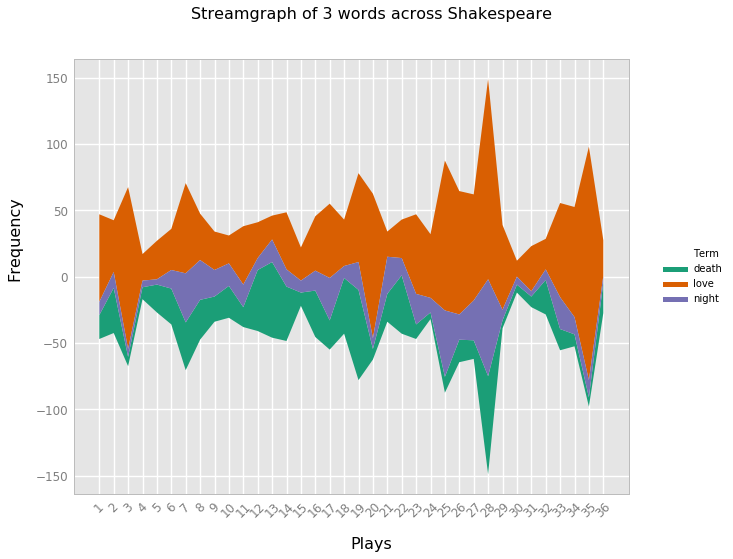

                           0
1   AllsWellThatEndsWell.txt
2    AnthonyAndCleopatra.txt
3            AsYouLikeIt.txt
4         ComedyOfErrors.txt
5             Coriolanus.txt
6              Cymbeline.txt
7                 Hamlet.txt
8           JuliusCaesar.txt
9           KingHenry4_1.txt
10          KingHenry4_2.txt
11            KingHenry5.txt
12          KingHenry6_1.txt
13          KingHenry6_2.txt
14          KingHenry6_3.txt
15            KingHenry8.txt
16              KingJohn.txt
17              KingLear.txt
18          KingRichard2.txt
19          KingRichard3.txt
20      LovesLaboursLost.txt
21               Macbeth.txt
22     MeasureForMeasure.txt
23      MerchantOfVenice.txt
24   MerryWivesOfWindsor.txt
25  MidsummerNightsDream.txt
26   MuchAdoAboutNothing.txt
27               Othello.txt
28        RomeoAndJuliet.txt
29      TamingOfTheShrew.txt
30               Tempest.txt
31         TimonOfAthens.txt
32       TitusAndronicus.txt
33    TroilusAndCressida.txt
34          Tw

In [13]:
# Variables
streamOutput = "streamgraph.svg"
width = 14
height = 8
dpi = 300
color = 'Dark2'
fontSz = 16
angle = 45
hjust = 1
vjust = -0.02
xlabel = "Plays"
title = "Streamgraph of 3 words across Shakespeare"

# Plot
%matplotlib inline
p = ggplot(df, aes(x = "SeqNum", ymin = 'ymin', ymax = 'ymax', y = 'Freq', group = 'Term', fill = 'Term')) +\
    geom_ribbon() +\
    theme(axis_text_x = element_text(angle=angle, hjust = hjust)) +\
    scale_fill_brewer(type = 'qual', palette = color) +\
    xlab(element_text(text = xlabel, size = fontSz, vjust = vjust)) +\
    ylab(element_text(text = "Frequency", size = fontSz)) +\
    scale_x_continuous(breaks = list(range(1, len(words) + 1))) + \
    ggtitle(element_text(text = title, size = fontSz))

    
p.make()
plt.savefig(os.path.join(dataResults, streamOutput), width = width, height = height, dpi = dpi)

plt.show()

if singleDoc is False:
    print(dfU)

## VOILA!!